### Import Dataset

In [1]:
if 'google.colab' in str(get_ipython()):
    IN_COLAB = True
else:
    IN_COLAB = False

In [43]:
if IN_COLAB:
  %pip install pycocotools omrdatasettools > /dev/null
  %git clone https://github.com/cakarsubasi/omrtorch.git
  
  print('installed dependencies')


In [2]:

import mung
from pycocotools.coco import COCO
from omrdatasettools import Downloader, OmrDataset
import os

import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
import pandas as pd
from PIL import Image
import json

if IN_COLAB:
    from omrtorch.muscima_utils import *
    from omrtorch.visionutils.engine import train_one_epoch, evaluate
    from omrtorch.visionutils import utils
    from omrtorch.visionutils import transforms as T
    from torchvision.utils import draw_bounding_boxes
else:
    from datasets.MuscimaMeasures import *
    from visionutils.engine import train_one_epoch, evaluate
    from visionutils import utils
    from visionutils import transforms as T
    from torchvision.utils import draw_bounding_boxes
# MuscimaMeasures, getMeasureLabels, getListofClassNames

Initialized module


In [45]:
if IN_COLAB:
    downloader = Downloader()
    downloader.download_and_extract_dataset(dataset=OmrDataset.MuscimaPlusPlus_V2, 
                                            destination_directory='muscima')
    downloader.download_and_extract_dataset(dataset=OmrDataset.MuscimaPlusPlus_MeasureAnnotations,
                                            destination_directory="muscima/v2.0/data/measure")
    


In [3]:
imagepath = 'muscima/v2.0/data/images'
annotationpath = 'muscima/v2.0/data/measure/json'

In [4]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

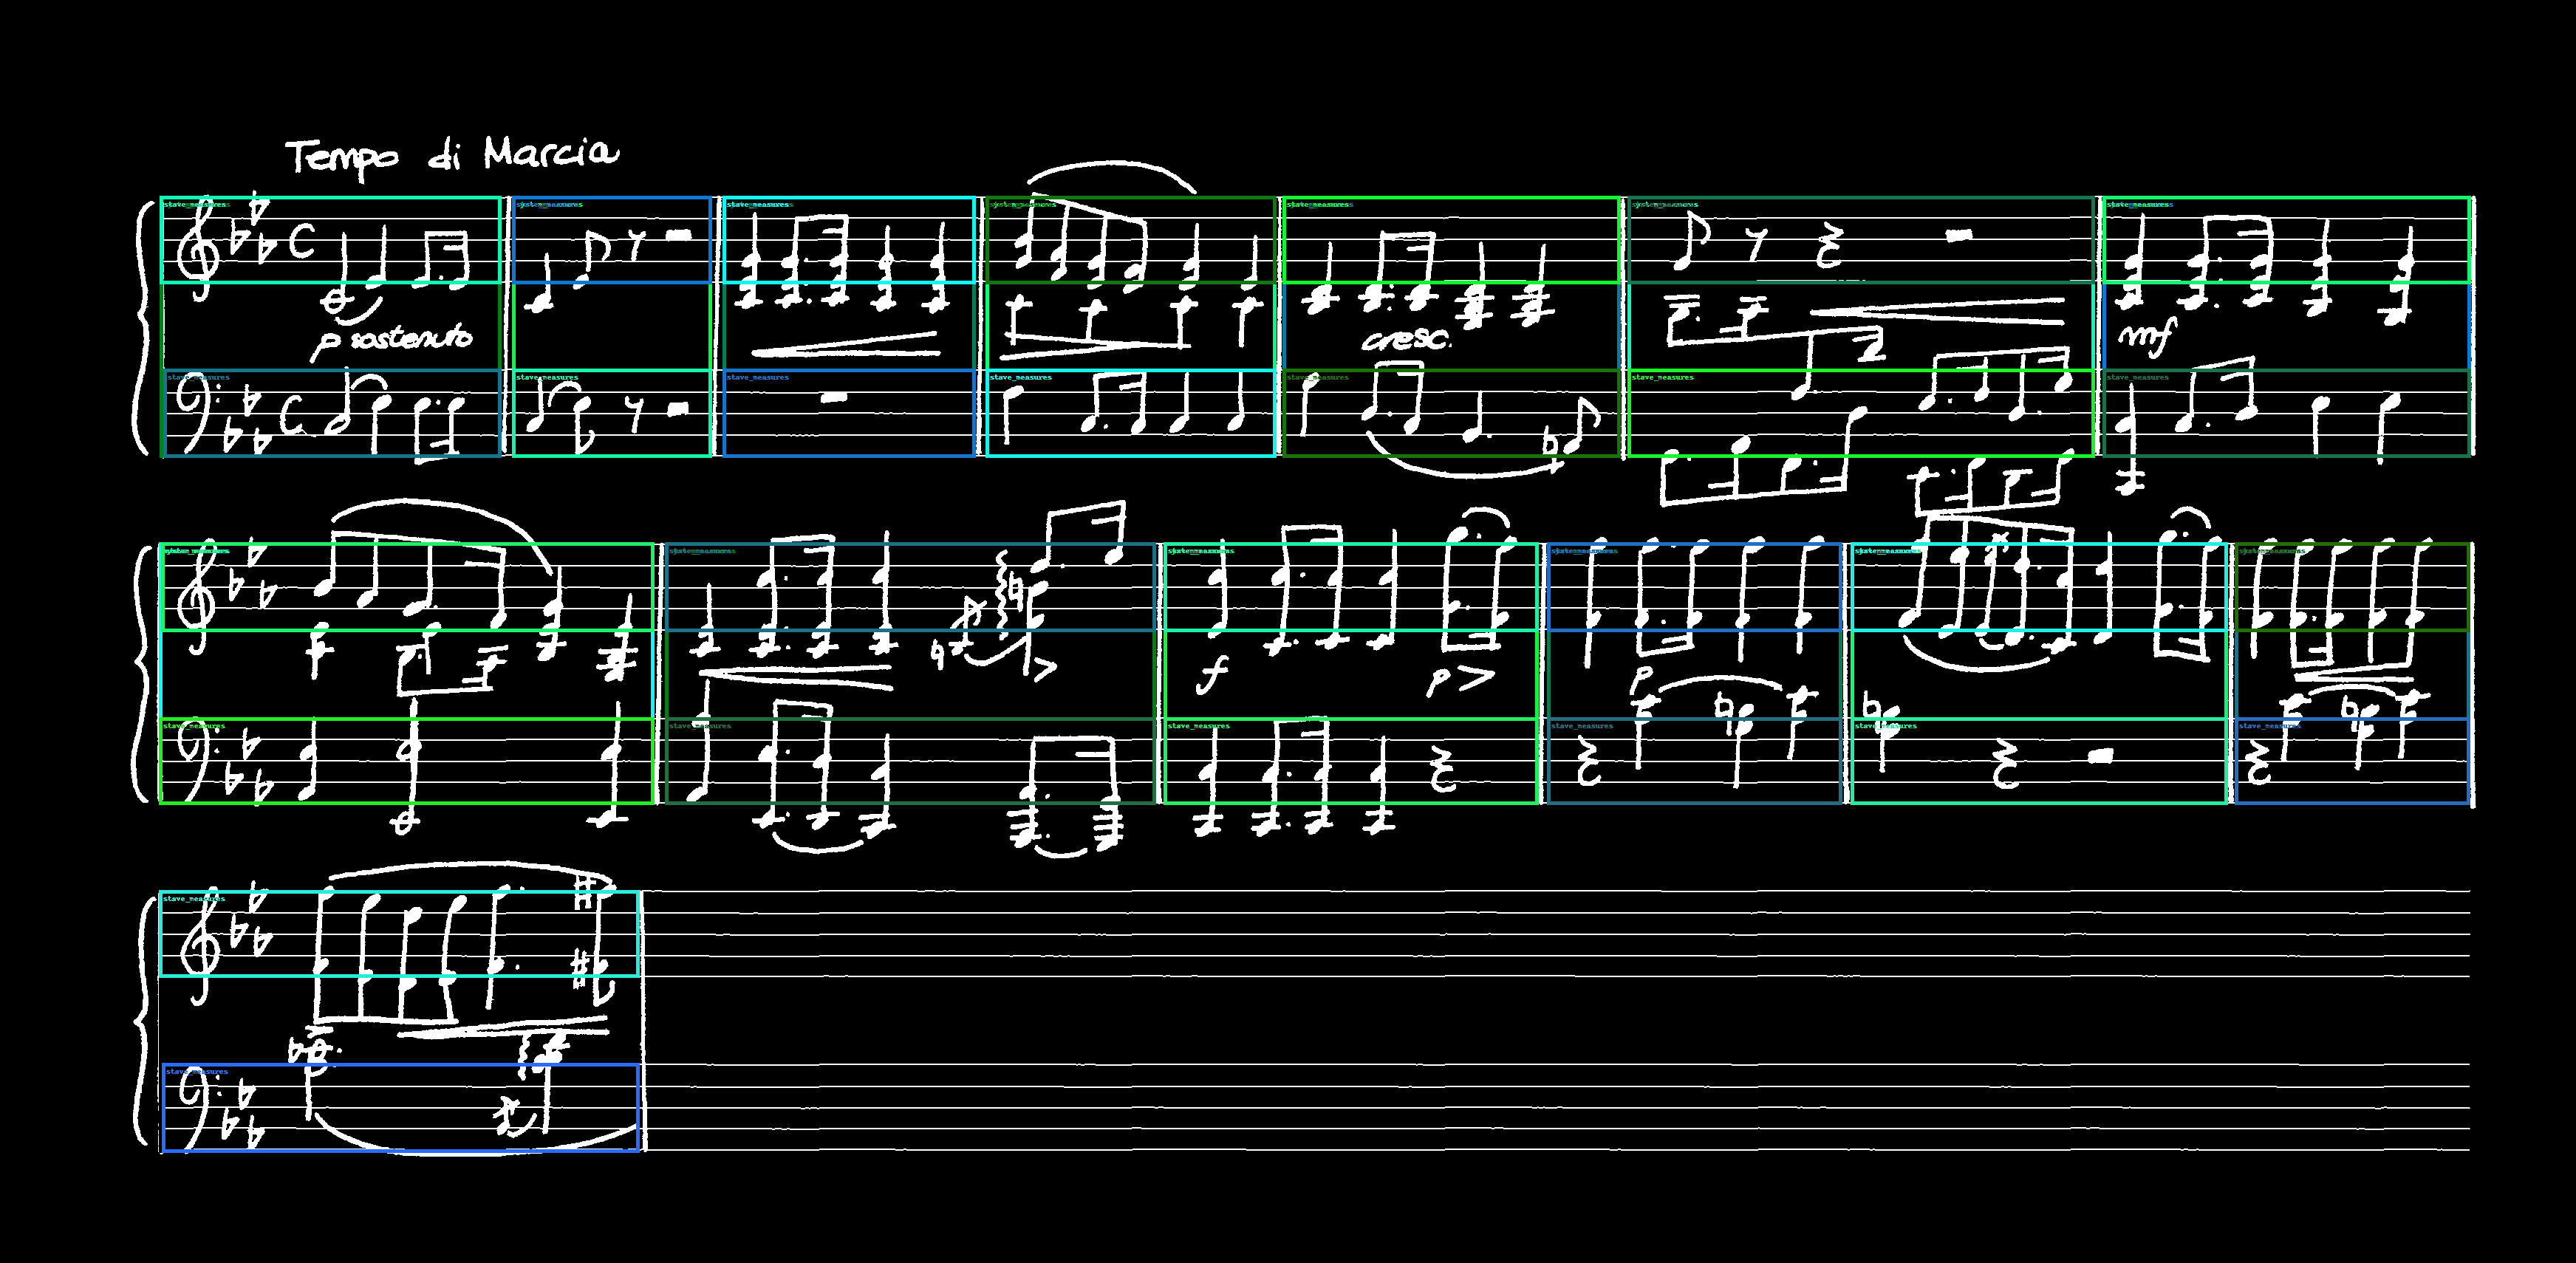

In [5]:
dataset = MuscimaMeasures(imagepath, annotationpath, transforms=get_transform(train=True))
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

sample_im, sample_ann = dataset[0]
sample_boxes = sample_ann['boxes']
sample_labels = sample_ann['labels']

sample_im = (255*sample_im).type(torch.ByteTensor)
sample_labels2 = getListofClassNames(sample_labels, dataset.label_list)

sample_im_with_bounding_boxes = draw_bounding_boxes(sample_im, sample_boxes, sample_labels2, width=5)

Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))

### Import Model

In [49]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Pretrained model
def get_faster_rcnn_with_n_classes(n: int):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=5)

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n)

  return model

def get_fcos_with_n_classes(n: int):
  model = torchvision.models.detection.fcos_resnet50_fpn(pretrained=False,
       pretrained_backbone=True, num_classes=n)

  return model

def get_gen_rcnn(n: int):
  pass

In [50]:
num_classes = 3

#model = get_faster_rcnn_with_n_classes(num_classes)
#model = get_fcos_with_n_classes(num_classes)

In [51]:
from datasets import models

model = models.muscima_fpn_model(
    num_classes=num_classes,
    backbone='resnet50',
    )

In [52]:
# Test

images, targets = next(iter(dataloader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

In [7]:
dataset = MuscimaMeasures(imagepath, annotationpath, transforms=get_transform(train=True))
dataset_test = MuscimaMeasures(imagepath, annotationpath, transforms=get_transform(train=False))

#splits
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

print(len(dataset))
print(len(dataset_test))

#dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

100
40


In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005)

# learning rate 10x reduction every three epocs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=)

In [16]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 20

run_training_and_validation = True

if run_training_and_validation:
  print("training for {num_epochs} epochs.")
  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

training for {num_epochs} epochs.
Epoch: [0]  [ 0/50]  eta: 0:00:49  lr: 0.000002  loss: 0.4302 (0.4302)  loss_classifier: 0.1318 (0.1318)  loss_box_reg: 0.1678 (0.1678)  loss_objectness: 0.0493 (0.0493)  loss_rpn_box_reg: 0.0814 (0.0814)  time: 0.9811  data: 0.0550  max mem: 3867
Epoch: [0]  [10/50]  eta: 0:00:36  lr: 0.000023  loss: 0.5016 (0.4935)  loss_classifier: 0.1746 (0.1836)  loss_box_reg: 0.1806 (0.1889)  loss_objectness: 0.0367 (0.0419)  loss_rpn_box_reg: 0.0791 (0.0790)  time: 0.9131  data: 0.0661  max mem: 4440
Epoch: [0]  [20/50]  eta: 0:00:25  lr: 0.000043  loss: 0.4951 (0.4761)  loss_classifier: 0.1717 (0.1724)  loss_box_reg: 0.1806 (0.1869)  loss_objectness: 0.0307 (0.0354)  loss_rpn_box_reg: 0.0749 (0.0815)  time: 0.8459  data: 0.0637  max mem: 4440
Epoch: [0]  [30/50]  eta: 0:00:16  lr: 0.000063  loss: 0.4958 (0.5247)  loss_classifier: 0.1781 (0.1844)  loss_box_reg: 0.1858 (0.1916)  loss_objectness: 0.0344 (0.0388)  loss_rpn_box_reg: 0.0817 (0.1099)  time: 0.8030  da

### Visualize Results

In [17]:
def visualize_bboxes(image, target, labels=None, threshold=0.5):
    colors = ['000000', 'red', 'blue', 'green', 'yellow']
    sample_boxes = target['boxes']
    sample_scores = target['scores']
    sample_labels = target['labels']
    idx = torch.where(sample_scores > threshold)
    boxes_sliced = sample_boxes[idx]
    labels_sliced = sample_labels[idx].tolist()
    colors_list = None
    labels_list_str = None
    if labels is not None:
        labels_list_str = list(labels[val] for val in labels_sliced)
        colors_list = list(colors[val] for val in labels_sliced)
    sample_image = (image*255).type(torch.ByteTensor)

    sample_im_with_bounding_boxes = draw_bounding_boxes(sample_image, boxes_sliced, labels_list_str, colors=colors_list, width=3, font_size=32)

    return Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))


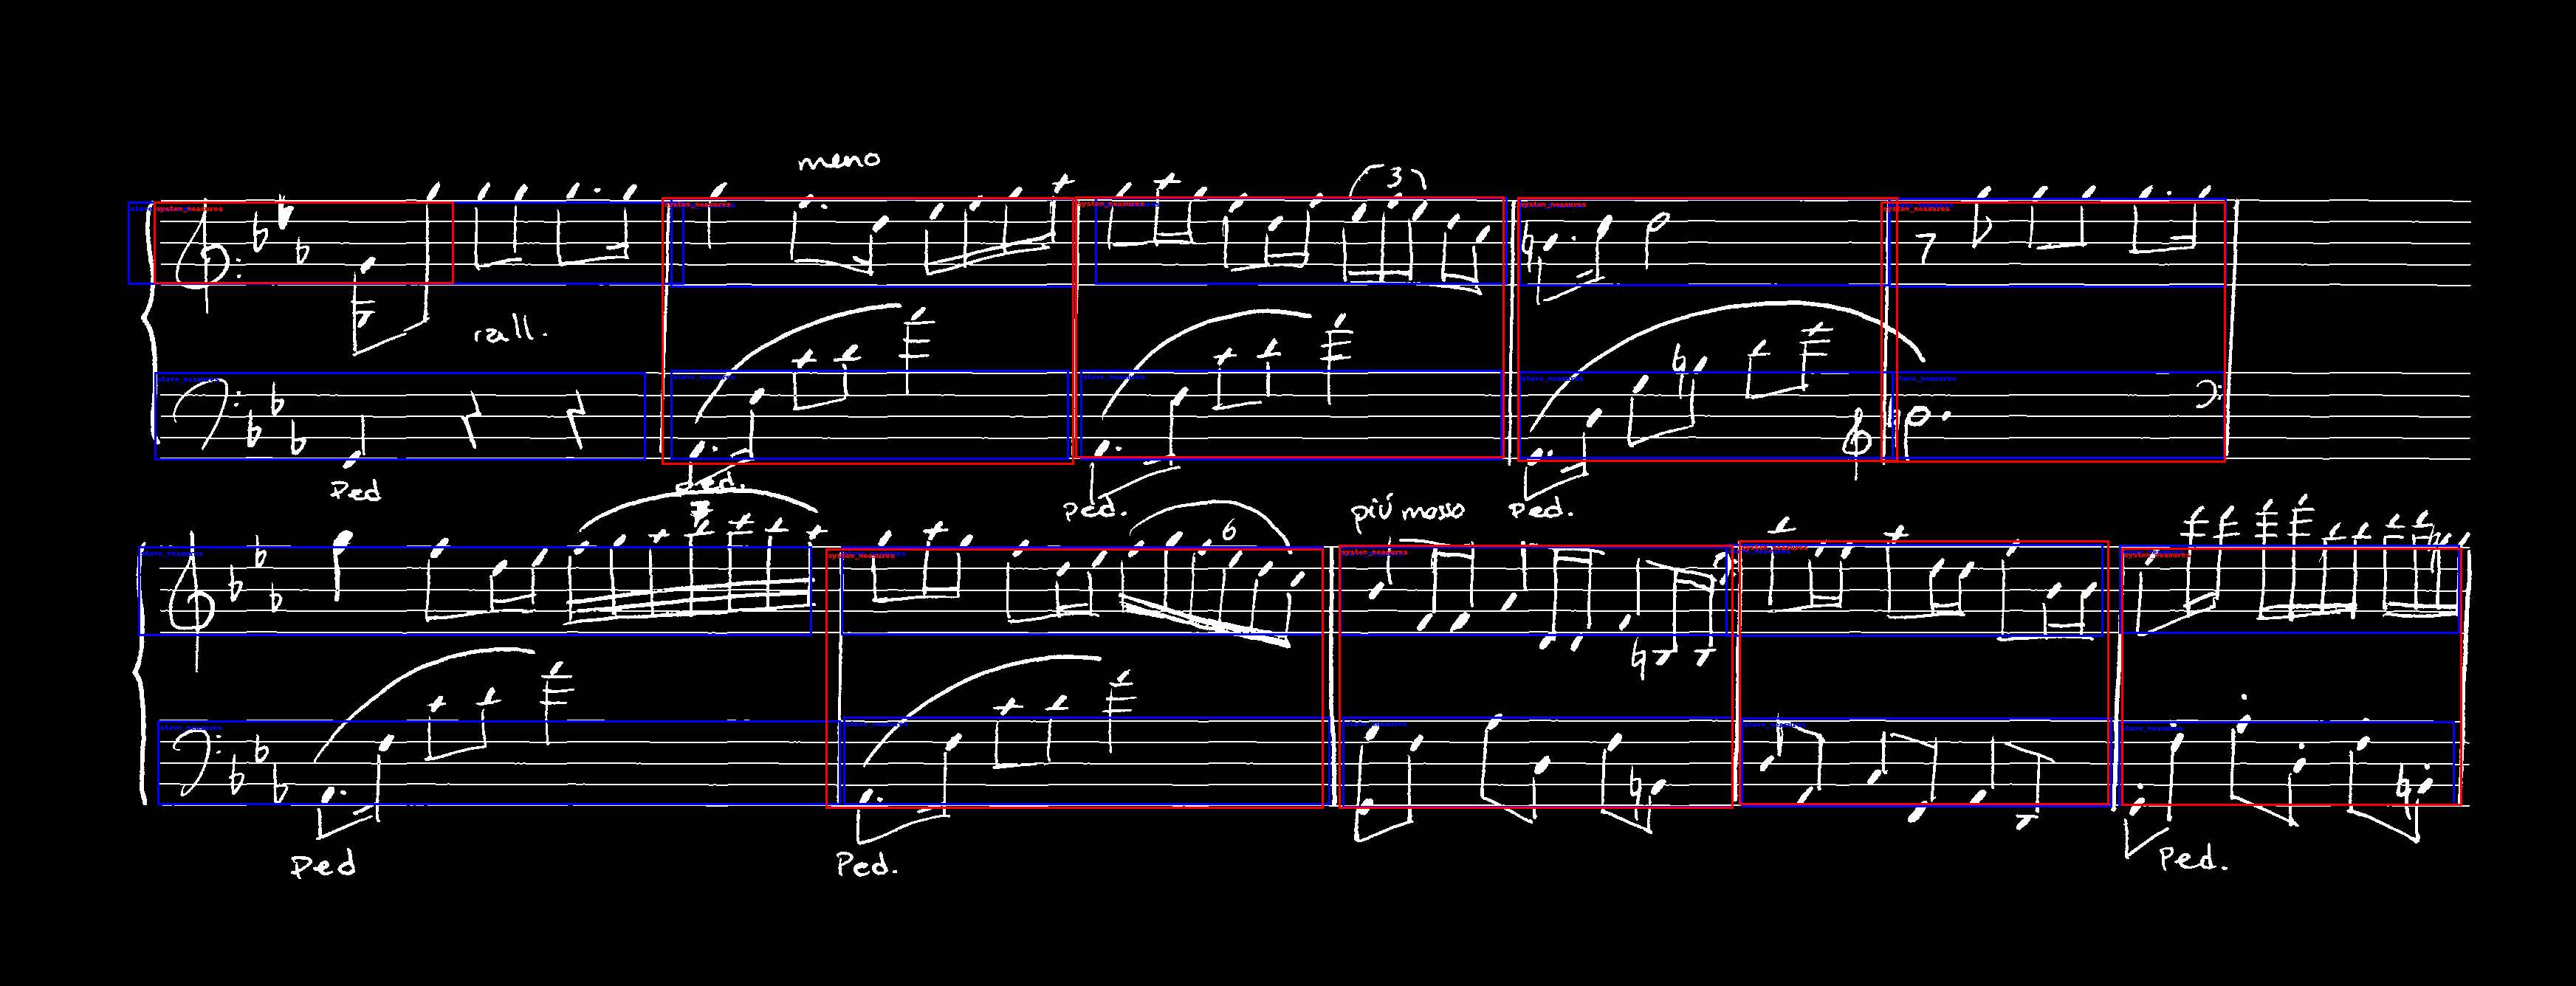

In [19]:
image_index = 0

model.eval()
if torch.cuda.is_available():
  torch.cuda.synchronize()
hacky_dataset = list(iter(data_loader_test))
#image = list(img.to(torch.device('cuda')) for img in image)
image, target = hacky_dataset[image_index]
image = list(img.to(torch.device('cuda')) for img in image)
detections = model(image)
labels = {1: 'system_measures', 2: 'stave_measures'}
visualize_bboxes(image[0], detections[0], labels, threshold=0.90)

In [29]:
hacky_dataset[0]

((tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),),
 ({'boxes': tensor([[ 217.,  270.,  893.,  623.],
           [ 908.,  270., 1451.,  623.],
           [1463.,  270., 2041.,  623.],
           [2053.,  270., 2550.,  623.],
           [2560.,  270., 3013.,  623.],
           [ 216.,  738., 1133., 1094.],
           [1143.,  738., 1800., 1094.],
           [1811.,  738., 2346., 1094.],
           [2361.,  738., 2859., 1094.],
           [2878.,  738., 3329., 1094.],
           [ 217.,  270.,  893.,  388.],
           [ 908.,  270., 1451.,  388.],
           [1463.,  270., 2041.,  388.],
           [2053.,  270., 2550.,  388.],
           [2560.,  270., 3013.,  388.],
           [ 217.,  503.,  893.,  623.],
           [ 908.,  503., 1451.,  623.],
           [146

In [17]:
detections[0]['scores']

tensor([0.9994, 0.9993, 0.9993, 0.9993, 0.9992, 0.9992, 0.9991, 0.9991, 0.9987,
        0.9986, 0.9984, 0.9981, 0.9970, 0.9965, 0.9961, 0.9961, 0.9961, 0.9954,
        0.9946, 0.9936, 0.9930, 0.9928, 0.9906, 0.9897, 0.9897, 0.9647, 0.9394,
        0.9312, 0.9264, 0.8925, 0.6707, 0.5965, 0.5596, 0.2475, 0.2256, 0.1923,
        0.1809, 0.1629, 0.1546, 0.1399, 0.1384, 0.1274, 0.1135, 0.1040, 0.0902,
        0.0851, 0.0697, 0.0519], device='cuda:0', grad_fn=<IndexBackward0>)

### Save Model

In [ ]:
# Model state_dict
#print("Model's state dict:")
#for param_tensor in model.state_dict():
#  print(param_tensor, "\t", model.state_dict()[param_tensor].size())
#
#print()
#
## Optimizer state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#  print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
# Example only save parameters
# SAVE_PARAMETERS = "state_dict_model.pt"
# 
# torch.save(model.state_dict(), SAVE_PARAMETERS)
# 
# model2 = get_faster_rcnn_with_n_classes(2)
# model2.load_state_dict(torch.load(SAVE_PARAMETERS))
# 
# model2.eval()

In [60]:
# Example save everything
SAVE_ENTIRE_MODEL = "measures_test.pt"

torch.save(model, SAVE_ENTIRE_MODEL)

model3 = torch.load(SAVE_ENTIRE_MODEL)
model3.eval()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 8.00 GiB total capacity; 6.65 GiB already allocated; 0 bytes free; 6.78 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF